**实验目标：**
通过本实验，你将学习并实践信号处理中的三个任务：线性预测合成法、griffin-lim算法，和 （选做）基于深度学习的语音合成和语音转换。

**实验方法：**


**1. 线性预测合成法**
  - 学习基于线性预测系数和预测误差的语音合成原理，分析自然语音样本，计算出LPC系数，建立信号产生模型，从而合成出语音。
  - 使用 librosa 库或其他音频处理库加载音频数据。
  - 求每帧的LPC系数与预测误差，然后合成语音。
  - 编写代码以可视化生成结果，将生成的音频和原始音频进行比较。

**2. griffin-lim算法**
  - 学习Griffin-Lim算法的原理，从频谱图中生成语音。
  - 使用 librosa 库加载语音，然后得到频谱。
  - 使用迭代的方式，从给定时频谱去重建相位信息，其迭代目标是让重建信号的时频谱与给定的时频谱的均方误差越小越好。
  - 编写代码以可视化生成结果，将生成的音频和原始音频进行比较。


**3. （选做）基于深度学习的语音合成和语音转换**
  - 在 github 上任选一个基于深度学习的语音合成或者语音转化的项目，尝试进行模型推理，实现文本转换语音，或者实现语音音色的转换。
  - 了解其中的实现过程和模型架构，并给出解释

  
**实验要求：**

开展上述实验，并可视化实验结果，并保存图片到本地。后续尝试自己录制一段音频，完成实验。

In [1]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import lfilter
from IPython.display import Audio, display

In [2]:
#录制音频的函数，首先使用给定的音频完成实验，后续再使用录制的音频。
def record_audio(duration):
    import pyaudio
    import wave

    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    WAVE_OUTPUT_FILENAME = "demo.wav"

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("* 录音中...")

    frames = []

    for i in range(0, int(RATE / CHUNK * duration)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* 录音结束!")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    
record_audio(duration=5) #录音5秒,并保存为demo.wav

* 录音中...
* 录音结束!


In [2]:
def enframe(x, win, inc=None):
    nx = len(x)
    if isinstance(win, list) or isinstance(win, np.ndarray):
        nwin = len(win)
        nlen = nwin  # 帧长=窗长
    elif isinstance(win, int):
        nwin = 1
        nlen = win  # 设置为帧长
    if inc is None:
        inc = nlen
    nf = (nx - nlen + inc) // inc
    frameout = np.zeros((nf, nlen))
    indf = np.multiply(inc, np.array([i for i in range(nf)]))
    for i in range(nf):
        frameout[i, :] = x[indf[i]:indf[i] + nlen]
    if isinstance(win, list) or isinstance(win, np.ndarray):
        frameout = np.multiply(frameout, np.array(win))
    return frameout

实验3-1: 使用线性预测器实现信号还原

对于线性预测器$\hat s(n)=\sum\limits_{i=1}^pa_is(n-i)$，其误差为$e(n)=s(n)-\hat s(n)$，那么在预测误差$e(n)$和预测系数$a_i$已知的情况下，就可以求出合成语音。

所有需要补充的代码都注释有TODO, 按要求补充即可

In [3]:
def Filpframe_OverlapS(x, win, inc):
    """
    基于重叠存储法的信号还原函数
    :param x: 分帧数据
    :param win: 窗
    :param inc: 帧移
    :return:
    """
    nf, slen = x.shape
    nx = (nf - 1) * inc + slen
    frameout = np.zeros(nx)
    x = x / win
    for i in range(nf):
        frameout[slen + (i - 1) * inc:slen + i * inc] += x[i, slen - inc:]
    return frameout
    
    
def lpc_coeff(s, p):
    """
    :param s: 一帧数据
    :param p: 线性预测的阶数
    :return:
    """
    n = len(s)
    # 计算自相关函数
    Rp = np.zeros(p)
    for i in range(p):
        Rp[i] = np.sum(np.multiply(s[i + 1:n], s[:n - i - 1]))
    Rp0 = np.matmul(s, s.T)
    Ep = np.zeros((p, 1))
    k = np.zeros((p, 1))
    a = np.zeros((p, p))
    # 处理i=0的情况
    Ep0 = Rp0
    k[0] = Rp[0] / Rp0
    a[0, 0] = k[0]
    Ep[0] = (1 - k[0] * k[0]) * Ep0
    # i=1开始，递归计算
    if p > 1:
        for i in range(1, p):
            k[i] = (Rp[i] - np.sum(np.multiply(a[:i, i - 1], Rp[i - 1::-1]))) / Ep[i - 1]
            a[i, i] = k[i]
            Ep[i] = (1 - k[i] * k[i]) * Ep[i - 1]
            for j in range(i - 1, -1, -1):
                a[j, i] = a[j, i - 1] - k[i] * a[i - j - 1, i - 1]
    ar = np.zeros(p + 1)
    ar[0] = 1
    ar[1:] = -a[:, p - 1]
    G = np.sqrt(Ep[p - 1])
    return ar, G

In [5]:
input_path = "C7_2_y.wav" # 或者是自己录制的 demo.wav
display(Audio(input_path))

In [6]:
fs, data = wavfile.read(input_path)
data = data / (2 ** (16 - 1))
print(fs)
data -= np.mean(data)
data /= np.max(np.abs(data))
N = len(data)
time = [i / fs for i in range(N)]  # 设置时间
# 设置线性预测的阶数和窗长、帧移
p = 8
wlen = int(0.001 * fs)  # 窗长为1ms
inc = int(0.0002* fs)  # 帧移为0.2ms

msoverlap = wlen - inc
y = enframe(data, wlen, inc)
fn = y.shape[0]
Acoef = np.zeros((y.shape[0], p + 1))
resid = np.zeros(y.shape)
synFrame = np.zeros(y.shape)

8000


In [7]:
# 求每帧的LPC系数与预测误差
for i in range(fn):
    a, _ = lpc_coeff(y[i, :], p)
    Acoef[i, :] = a
    resid[i, :] = lfilter(a, [1], y[i, :])

# 语音合成
for i in range(fn):
    synFrame[i, :] = lfilter([1], a, resid[i, :])

outspeech = Filpframe_OverlapS(synFrame, np.hamming(wlen), inc)

display(Audio(outspeech, rate=fs))

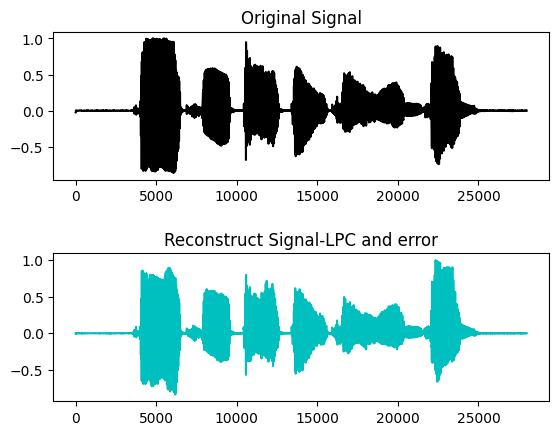

In [8]:
plt.subplot(2, 1, 1)
plt.plot(data / np.max(np.abs(data)), 'k')
plt.title('Original Signal')
plt.subplot(2, 1, 2)
plt.title('Reconstruct Signal-LPC and error')
plt.subplots_adjust(hspace=0.5)
plt.plot(outspeech / np.max(np.abs(outspeech)), 'c')

实验3-2: griffin-lim算法

所有需要补充的代码都注释有TODO, 按要求补充即可

In [5]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

n_fft, hop_length, win_length = 720, 160, 720 # TODO 尝试改变参数
# n_fft：它代表快速傅里叶变换（FFT）的点数，用于将音频信号从时域转换为频域。
# hop_length：它表示相邻窗口之间的帧移，也可以理解为窗口的步长。
# in_length：它是每个窗口的长度。

def _griffin_lim(S, gl_iters):
    #随机生成一个与频谱图S形状相同的复数数组（相位谱），其中每个元素都是在[0, 2π)范围内的随机相位值
    angles = np.exp(2j * np.pi * np.random.rand(*S.shape)) # TODO 
    #计算频谱图S的绝对值(幅度谱），将angles转换为复数类型，其中包含相位信息；二者相乘，将幅度和相位信息结合在一起，得到一个复数数组S_complex 
    S_complex = np.abs(S) * angles.astype(np.complex128)# TODO 

    #用相位谱和已知的幅度谱经过ISTFT合成新语音
    y = _istft(S_complex) # TODO 使用istft转换会音频
    
    for i in range(gl_iters):
        #对合成的语音做STFT，得到新相位谱
        angles =np.exp(1j * np.angle(_stft(y))) # TODO
        # 首先对当前的音频信号y进行短时傅里叶变换（_stft(y)），然后取其相位。
        # np.angle()函数返回复数的相位角，然后通过np.exp(1j * ...)将相位角转换回复数形式，以便与频谱图的幅度相匹配。
        
        #用相位谱和已知的幅度谱合成语音
        y = _istft(S_complex * angles)
    return y

#短时傅里叶变换，返回经过STFT处理后的音频信号的频谱表示，返回值是一个复数数组，表示音频信号在频域中的幅度和相位信息
def _stft(y):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

#逆短时傅里叶变换，将频域表示的音频信号转换回时域
def _istft(y):
    return librosa.istft(y, hop_length=hop_length, win_length=win_length)

In [6]:
input_path = "C7_2_y.wav" # 或者是自己录制的 demo.wav
display(Audio(input_path))

In [7]:
AudioData, sr = librosa.load(input_path, sr=16000, mono=True)  # 使用文件采样率
D = librosa.stft(AudioData, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

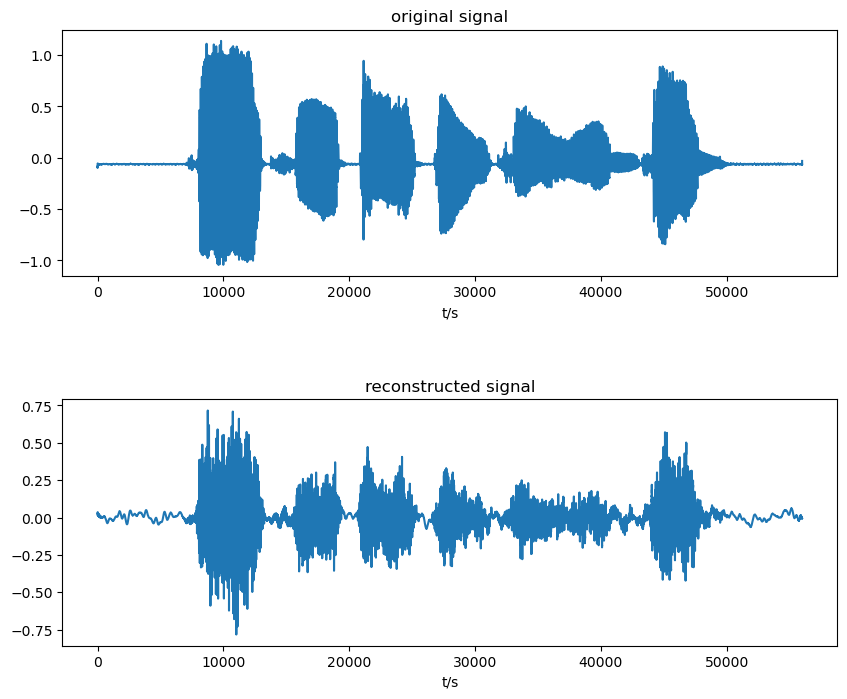

In [8]:
gl_iters =120 # TODO 设置 griffin_lim 算法重复迭代的次数
ReAudio = _griffin_lim(D, gl_iters)

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(AudioData)
plt.xlabel('t/s')
plt.title('original signal')
plt.subplot(2, 1, 2)
plt.plot(ReAudio)
plt.xlabel('t/s')
plt.title('reconstructed signal')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [9]:
display(Audio(ReAudio, rate=16000))

实验3-3（选做）: 基于深度学习的语音合成和语音转换

可参考的语音合成项目：
- https://github.com/ming024/FastSpeech2
- https://github.com/NVIDIA/tacotron2
- https://github.com/RVC-Boss/GPT-SoVITS

可参考的语音转换项目：
- https://github.com/PlayVoice/so-vits-svc-5.0
- https://github.com/RVC-Project/Retrieval-based-Voice-Conversion-WebUI